# Laplacian Associative Memory (LAM) - DEV 16

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

- sigmaX distribution = 0-1
- Changed _step function and binary state vector to range from -1 to 1
- End-to-end encoding

In [1]:
from nn import LAM
import libtools

In [2]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# np.random.seed(123)

---

#### LOAD DATA

In [4]:
src = np.load('../data/mat/SOM_orient_v1.npy')

print('Map:', src.shape)
print('Theta θ | min:', round(src.min(),4), 'max:', round(src.max(),4))

Map: (201, 201)
Theta θ | min: 0.0 max: 6.2832


In [5]:
img = np.array(PIL.Image.open("../data/images/coco/hercules.png").convert('L'), dtype=float)
img /= np.max(img) # Normalize

print('Image:', img.shape)
print('min:', round(img.min(),4), 'max:', round(img.max(),4))

Image: (201, 201)
min: 0.0039 max: 1.0


---

### GABOR

In [6]:
step = 20
f_size = 5

pad = int(step/2)
pad_im = np.pad(img, pad, mode='constant', constant_values=0)
features = np.zeros_like(pad_im)

for i in range(src.shape[0]):
    for j in range(src.shape[1]):
        arctan = src[i][j] - np.pi # Arc tangent | -π and π
        deg = np.rad2deg(arctan*0.5) # *0.5 to keep range between -90 and 90
        kernel = libtools.gabor_filter(2, 1, deg, samples=step, min=-f_size, max=f_size) # Orientation
        patch = pad_im[i:i+step, j:j+step]
        features[int(i+pad),int(j+pad)] = np.sum(patch * kernel) # Firing Rate / Response
        
features = features[pad:pad+src.shape[0],pad:pad+src.shape[1]]
activations = np.where(features > 0, 1, -1) # Heaviside step function

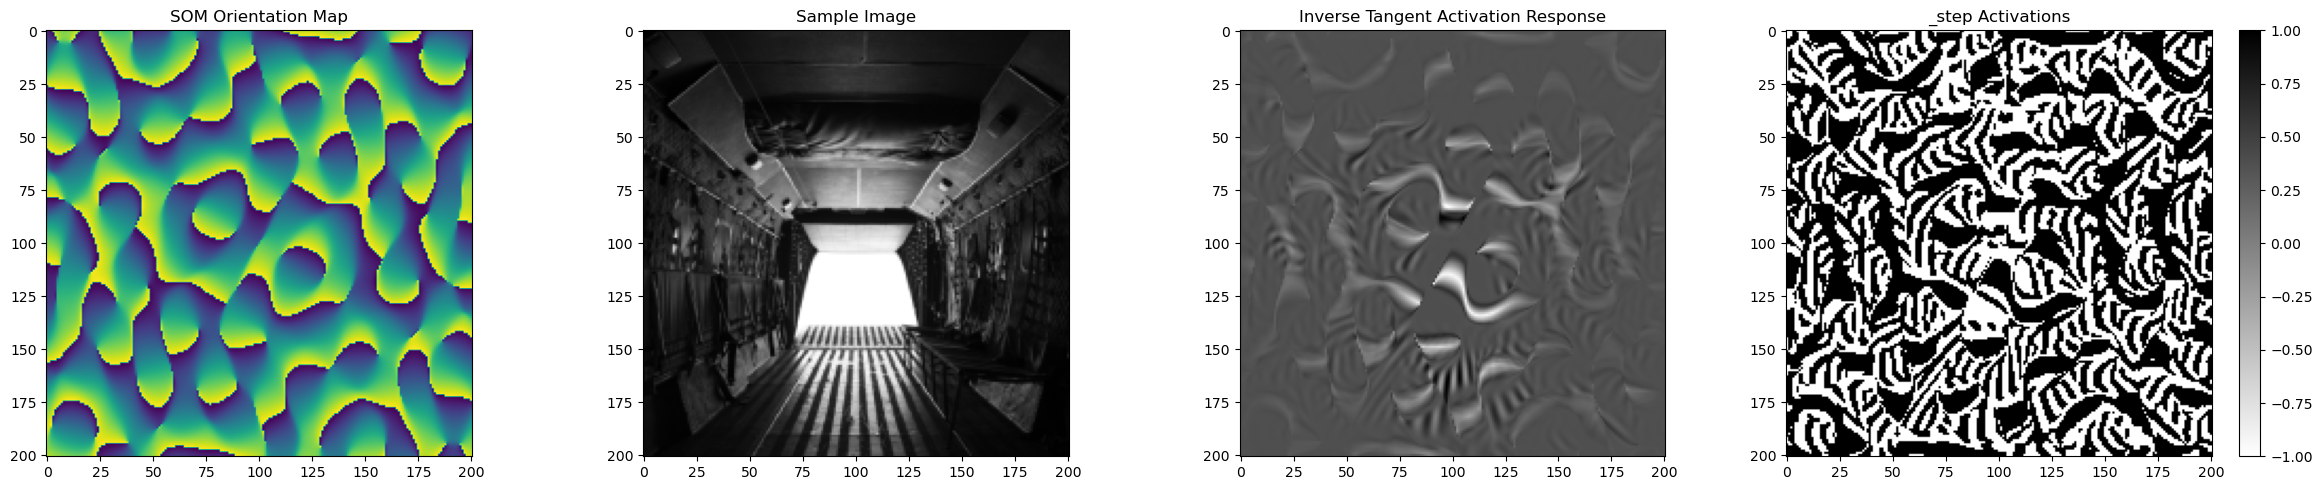

In [7]:
plt.figure(figsize=(24,5))
plt.subplot(1,4,1)
plt.imshow(src)
plt.title('SOM Orientation Map')

plt.subplot(1,4,2)
plt.imshow(img, 'gray')
plt.title('Sample Image')

plt.subplot(1,4,3)
plt.imshow(features, 'gray')
plt.title('Inverse Tangent Activation Response')

plt.subplot(1,4,4)
plt.imshow(activations, 'binary')
plt.title('_step Activations')
plt.colorbar()
plt.tight_layout()

---

### HYPER-PARAMETERS

In [8]:
src = libtools.downsample(src, 4)   # Resize SOM Orientation Map

N = 8192                            # Neurons | Default: 30000
prob = 0.1                          # Sparsity
eta = 0.01                          # Epsilon / Learning rate
epochs = 3000                       # Steps
gamma = 0.6                         # Inhibition ratio
norm_mode = 'asym'                  # Asymmetric Normalisation
alpha = -0.9                        # Ratio between local and global inhibition
P = src.shape[0] * src.shape[1]     # N Nodes

sigmaX = 1.0                        # Spatial Gaussian Scale
sigmaA = 0.1                        # Angular Component Scale

# Init condition (Center cell)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))
print('Start node:', start_node)

Start node: 1300


---

### COMPUTE

In [9]:
W = libtools.construct_SOAM(src, sigmaX, sigmaA)

In [10]:
_, v = libtools.GL_eigen(W, 'asym')

In [11]:
graph = LAM(N, P, prob, W, gamma, "asym")

In [12]:
print('Adjaceny Matrix Shape:', W.shape)
print('Node Shape:', graph.xi.shape)

Adjaceny Matrix Shape: (2601, 2601)
Node Shape: (8192, 2601)


In [13]:
### TESTING

Wnorm = np.diag(np.sum(W, axis=1)**-1)
H = Wnorm @ W
Wauto = (graph.xi @ graph.xi.T) / graph.NV
Whetero = (graph.xi_bias @ H @ graph.xi_bias.T) / graph.NV

In [14]:
### STOP - Simulation Below

In [15]:
graph._set_weight(alpha)
m_log, obj_log = graph.simulate_single(alpha, eta, epochs, start_node)
m = m_log[-1,:]

100%|██████████| 3000/3000 [01:37<00:00, 30.78it/s]


---

### PLOT

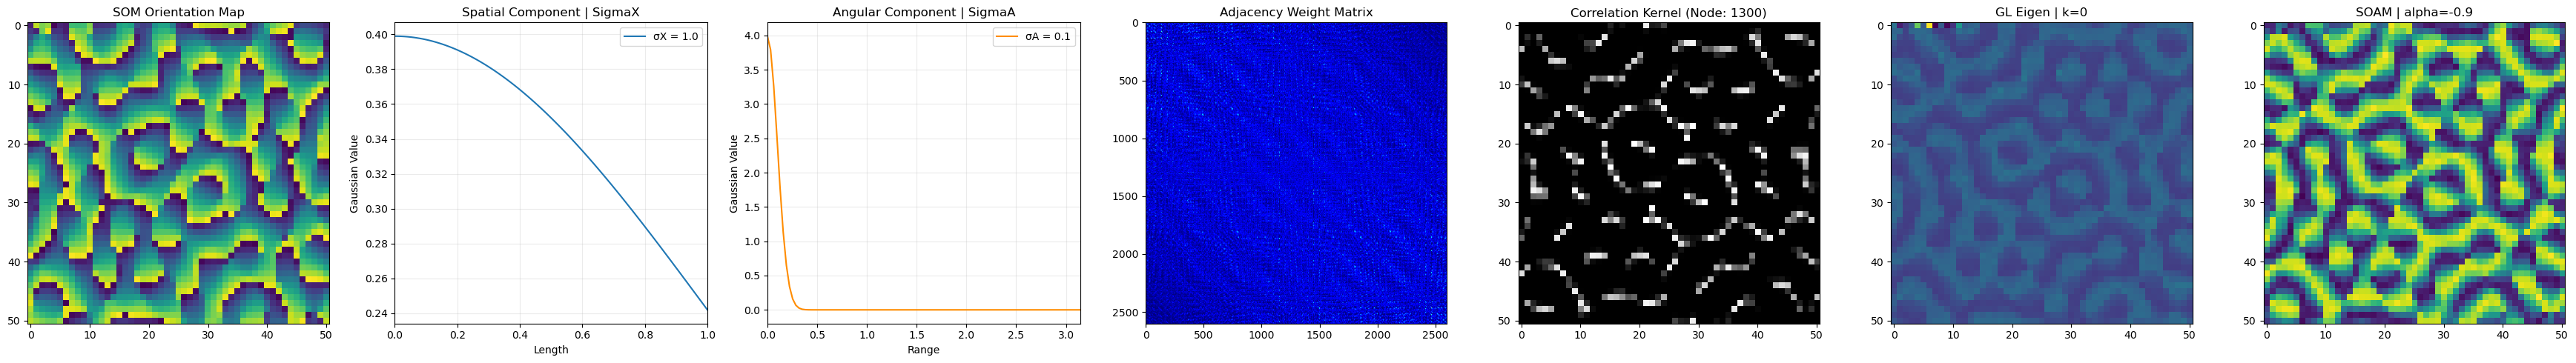

In [16]:
plt.figure(figsize=(35,5))
plt.subplot(1, 7, 1)
plt.imshow(src)
plt.title('SOM Orientation Map')

dist_s = np.linspace(0, 1, 100)
dist_a = np.linspace(0, np.pi, 100)

plt.subplot(1, 7, 2)
plt.plot(dist_s, libtools.gaussian(dist_s, sigmaX), label=f'σX = {sigmaX}')
plt.title('Spatial Component | SigmaX')
plt.xlabel('Length'), plt.ylabel('Gaussian Value')
plt.xlim([0, 1]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(1, 7, 3)
plt.plot(dist_a, libtools.gaussian(dist_a, sigmaA), 'darkorange', label=f'σA = {sigmaA}')
plt.title('Angular Component | SigmaA')
plt.xlabel('Range'), plt.ylabel('Gaussian Value')
plt.xlim([0, np.pi]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(1, 7, 4)
plt.imshow(W, 'jet')
plt.title('Adjacency Weight Matrix')

plt.subplot(1, 7, 5)
plt.imshow(W[start_node].reshape(src.shape), 'gray')
plt.title('Correlation Kernel (Node: ' + str(start_node) + ')')

plt.subplot(1, 7, 6)
k = 0
color_max = np.max(np.abs(v[:,k]))
plt.imshow(v[:,k].reshape(src.shape))
plt.title('GL Eigen | k='+ str(k))

plt.subplot(1, 7, 7)
color_max = np.max(np.abs(m))
plt.imshow(m.reshape(src.shape))
plt.title('SOAM | alpha=' + str(alpha))
plt.tight_layout()